In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
from scipy import signal

from filters import AdaptiveEqualizerAlamouti, CDCompensator, PulseFilter
from frequency_recovery import FrequencyRecovery
from modulation import (
    Demodulator,
    Demodulator16QAM,
    DemodulatorQPSK,
    Modulator,
    Modulator16QAM,
    ModulatorQPSK,
)
from receiver import Digital90degHybrid
from utils import normalize_power

In [3]:
def plot_signal(signal: np.ndarray, alpha=1.0, size=0.1) -> None:
    assert signal.ndim == 1
    assert signal.size > 0

    s_real = np.real(signal[:8192])
    s_imag = np.imag(signal[:8192])

    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 6))

    # Constellation diagram.
    ax = axs[0][0]
    ax.scatter(s_real, s_imag, alpha=alpha, s=size)
    ax.axis("equal")
    ax.set_xlabel("In-phase")
    ax.set_ylabel("Quadrature")
    ax.axhline(color="black")
    ax.axvline(color="black")

    # Unused plot.
    axs[1][0].set_axis_off()

    # Signal (real component).
    ax = axs[0][1]
    ax.stem(s_real)
    ax.set_xlim(-4, 128)
    ax.set_xlabel("Sample")
    ax.set_ylabel("In-phase")

    # Signal (imaginary component).
    ax = axs[1][1]
    ax.stem(s_imag)
    ax.set_xlim(-4, 128)
    ax.set_xlabel("Sample")
    ax.set_ylabel("Quadrature")

    # Spectrum.
    axs[0][2].magnitude_spectrum(signal.tolist(), sides="twosided")
    axs[1][2].phase_spectrum(signal.tolist(), sides="twosided")

    fig.tight_layout()

    plt.show()

In [4]:
# 256 GSa/s, stored as 16-bit signed integers
data_256i = np.ravel(scipy.io.loadmat("data_alamouti/capture_50G_S_-17.5.mat")["ch1"])

# Convert to cdouble, subtract the DC component, and normalize power
data_256d = data_256i.astype(np.cdouble)
# XXX data_256d -= data_256d.mean()
data_256d = normalize_power(data_256d)

# Reference data
# TODO also look at the transmitted data, and compare it with what is produced
# by the simulation
data_ref = np.ravel(scipy.io.loadmat("data_alamouti/AC_data.mat")["s_qam"])
data_ref = normalize_power(data_ref)
data_ref.size

32768

In [5]:
sx2 = np.ravel(scipy.io.loadmat("data_alamouti/AC_data.mat")["sx2"])
sy2 = np.ravel(scipy.io.loadmat("data_alamouti/AC_data.mat")["sy2"])

In [6]:
qpsk_sync = np.ravel(scipy.io.loadmat("data_alamouti/QPSK_sync.mat")["s"])
qpsk_sync.size

1024

In [7]:
assert np.allclose(sx2[:1024], qpsk_sync)
assert np.allclose(sy2[:1024], qpsk_sync)
assert np.allclose(sx2[1024:2048], qpsk_sync)
assert np.allclose(sy2[1024:2048], qpsk_sync)

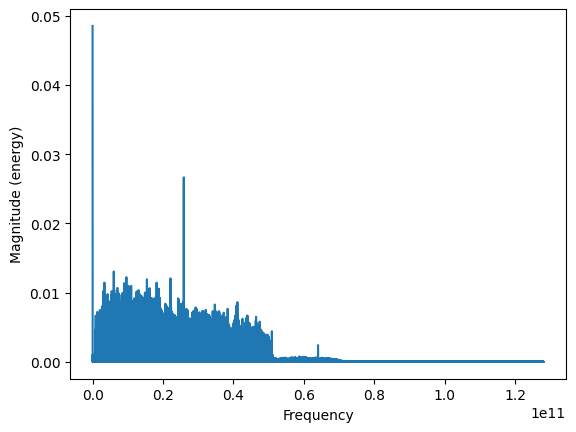

In [8]:
plt.magnitude_spectrum(data_256d.real.tolist(), Fs=256e9);

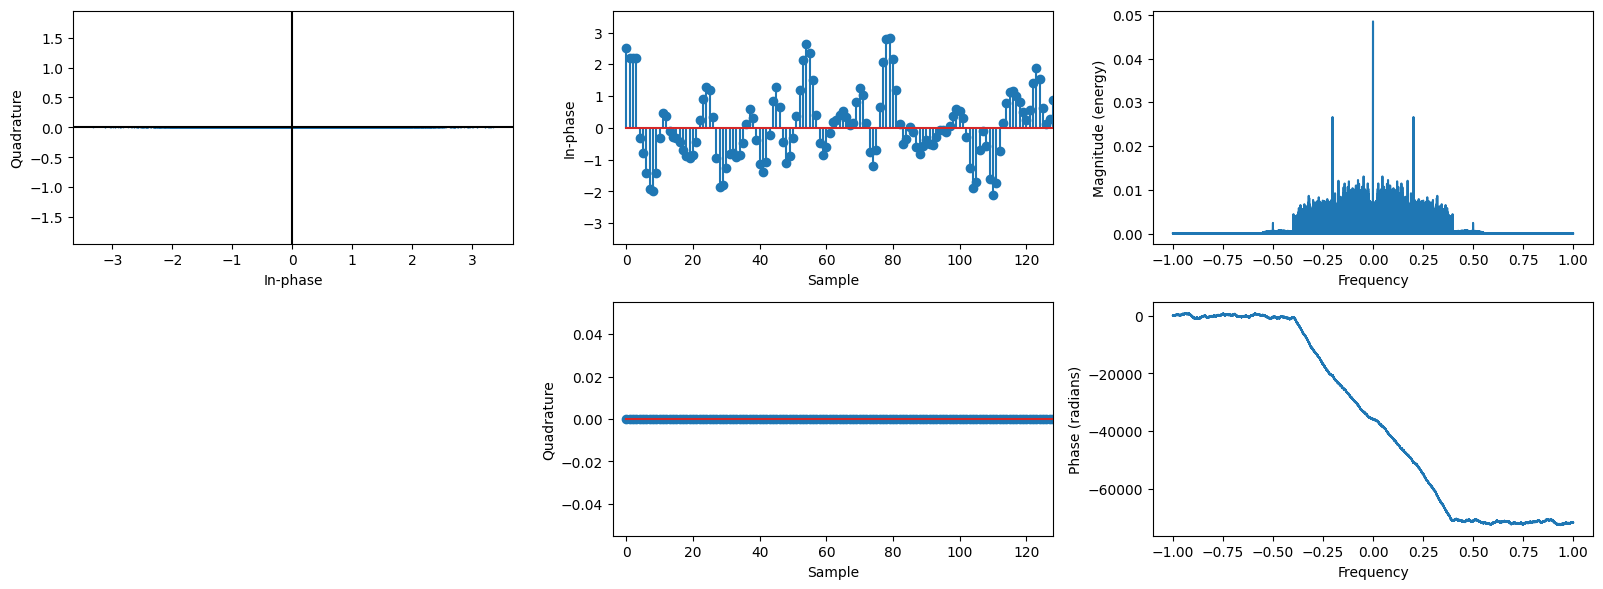

In [9]:
plot_signal(data_256d)

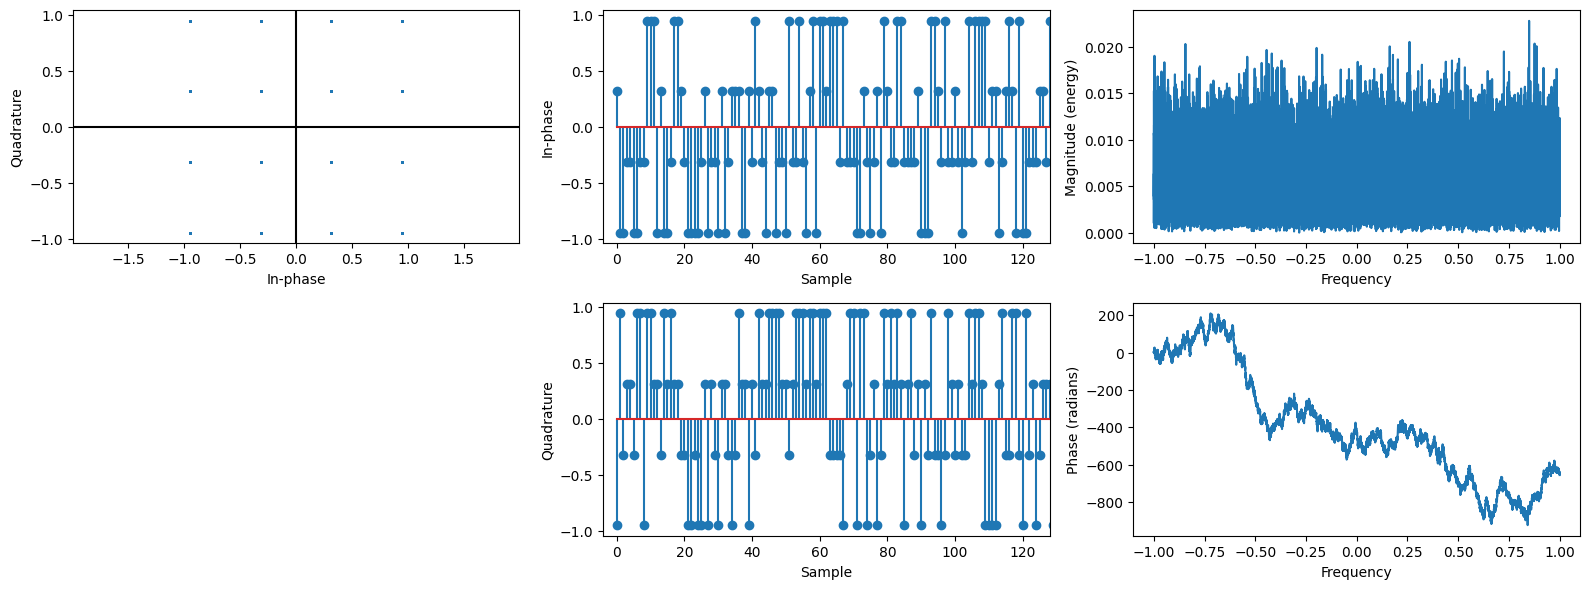

In [10]:
plot_signal(data_ref)

In [11]:
# Resample to 100 GSa/s (2 SpS)
data_100 = scipy.signal.resample_poly(data_256d, up=25, down=64)
data_100.shape

(585938,)

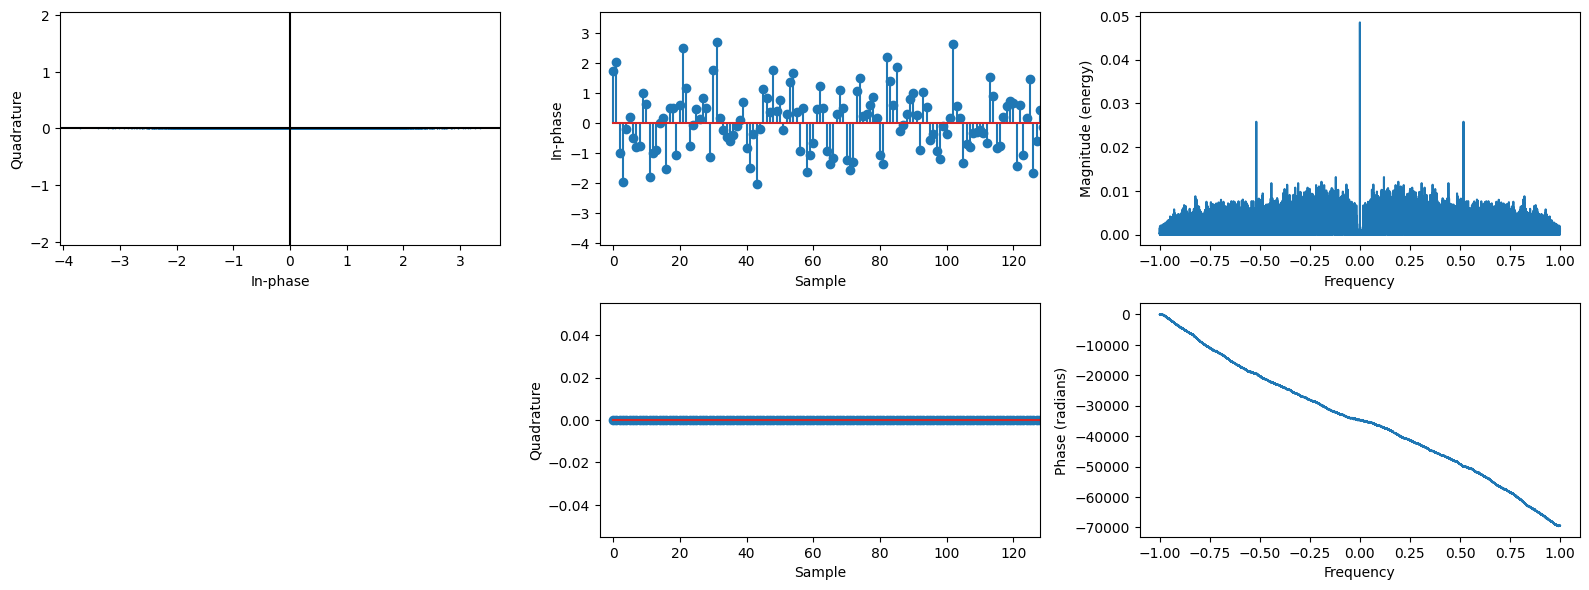

In [12]:
plot_signal(data_100)

In [13]:
# Peak in the spectrum is the IF
np.fft.fftfreq(data_100.size, d=1/100e9)[np.argmax(np.fft.fft(data_100))] / 1e9

0.0

In [14]:
# XXX the IF has to be negative for some reason (the spectrum is mirrored)
rx_if = Digital90degHybrid(-25.887, 100e9)(data_100)

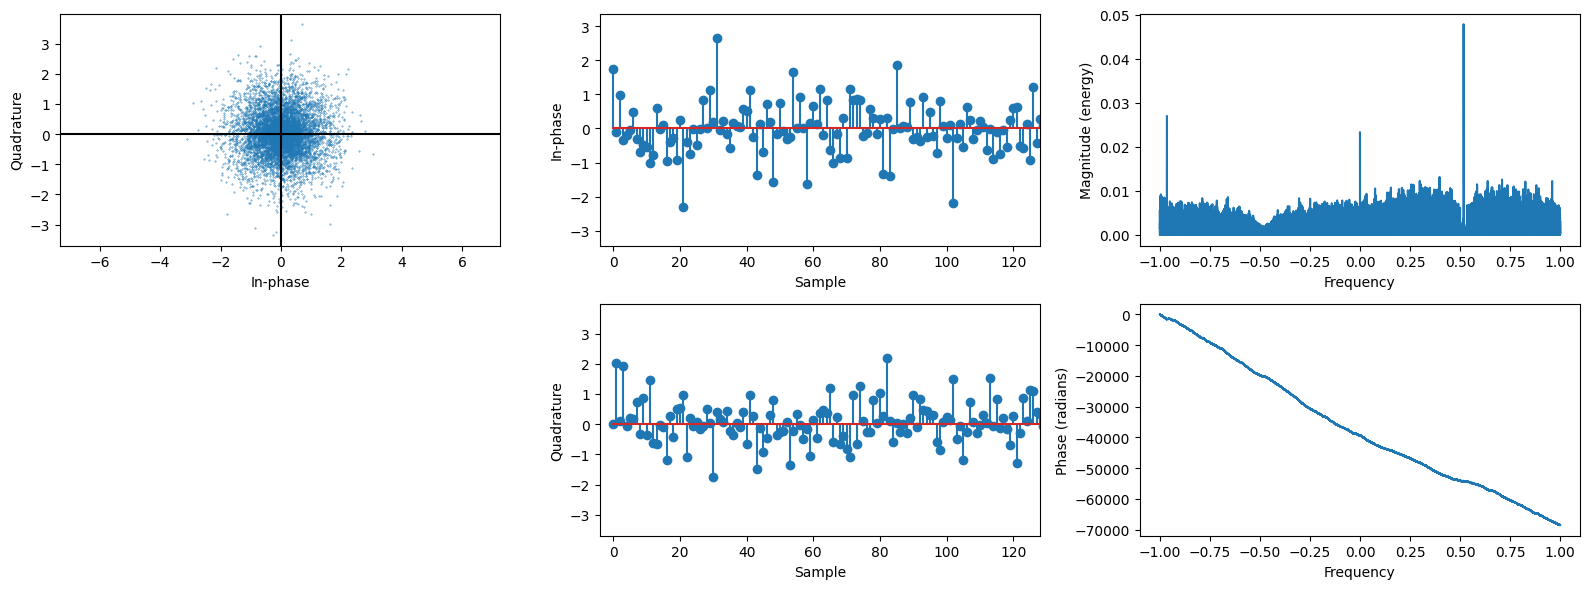

In [15]:
plot_signal(rx_if)

In [16]:
# 25 km of fibre.
# rx_cd = CDCompensator(25_000, 100e9, 2, 35, 0.01)(rx_if)

In [17]:
# plot_signal(rx_cd)

In [18]:
pf = PulseFilter(2, down=1)
pf.BETA = 0.01
pf.SPAN = 508
# rx_pf = pf(rx_cd) # XXX without frequency recovery
rx_pf = pf(rx_if) # XXX without frequency recovery

In [19]:
assert pf.impulse_response.size == 1016

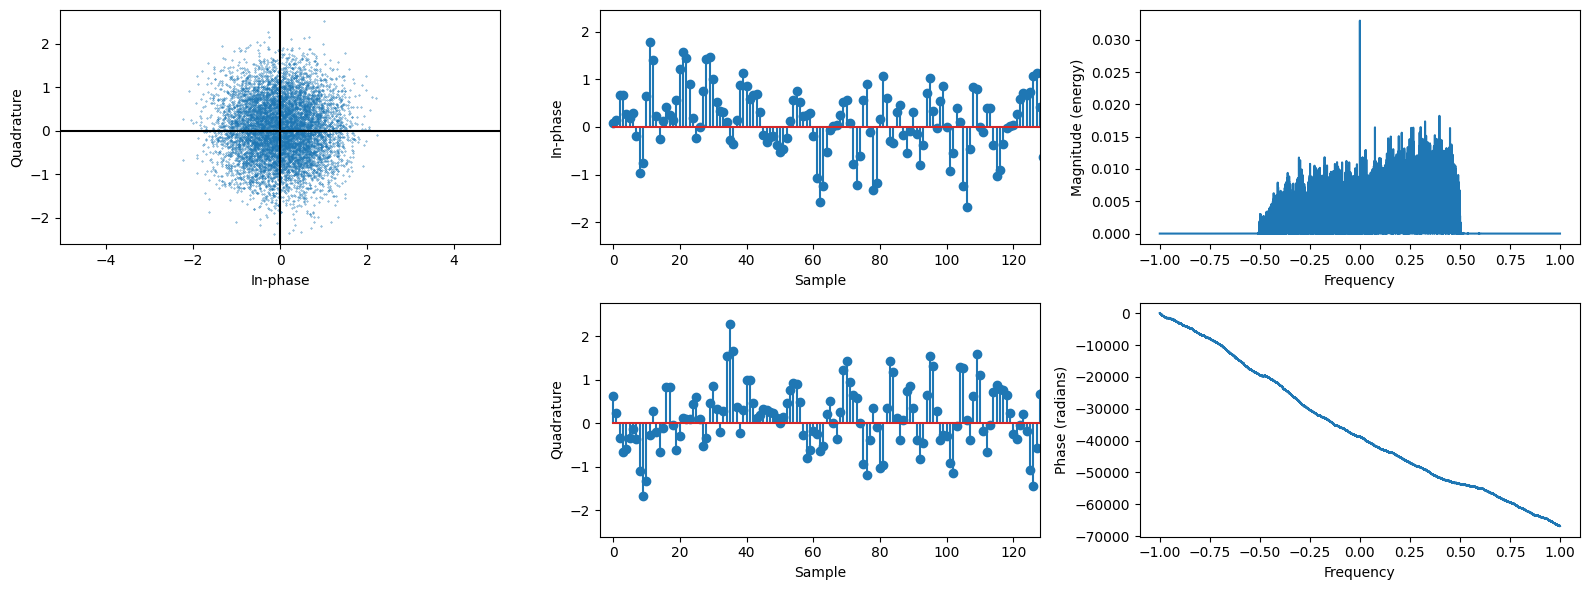

In [20]:
plot_signal(rx_pf)

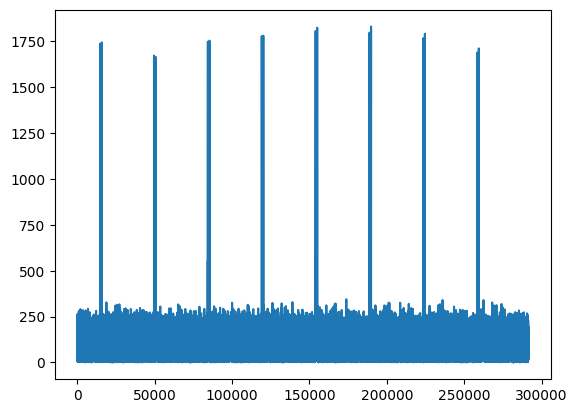

In [21]:
plt.plot(np.abs(np.correlate(rx_pf[::2], qpsk_sync)));

In [22]:
def find_lag(ref: np.ndarray, sig: np.ndarray) -> int:
    corr = np.abs(signal.correlate(ref, sig))
    lags = signal.correlation_lags(ref.size, sig.size)
    plt.plot(lags, corr)
    plt.show()
    lag = lags[np.argmax(corr)]
    return lag

In [23]:
def find_all_lags(ref: np.ndarray, sig: np.ndarray, threshold: float) -> int:
    corr = np.abs(signal.correlate(ref, sig))
    lags = signal.correlation_lags(ref.size, sig.size)
    lag = lags[corr > threshold]
    return lag

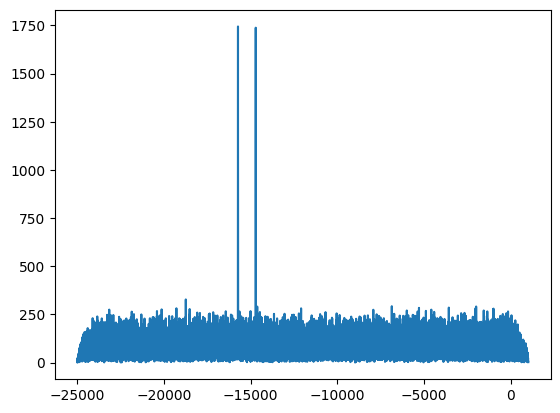

-15731

In [24]:
find_lag(qpsk_sync, rx_pf[0:50_000:2])

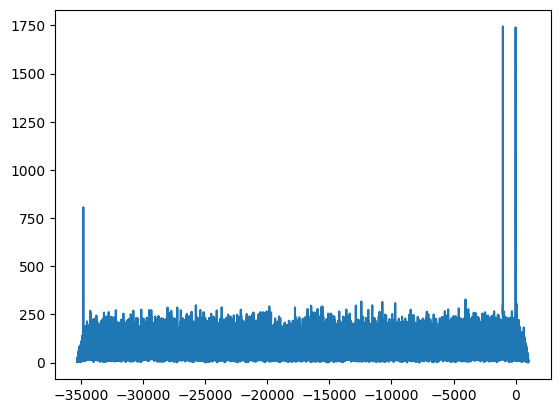

-1023

In [25]:
# qpsk_sync leads rx_pf by 14709 samples
find_lag(qpsk_sync, rx_pf[2*14708:2*50_000:2])

In [26]:
all_lags = find_all_lags(qpsk_sync, rx_pf[::2], 500)
all_lags

array([-259445, -259444, -259443, -259442, -259441, -259440, -259439,
       -258421, -258420, -258419, -258418, -258417, -258416, -258415,
       -224630, -224629, -224628, -224627, -224626, -224625, -224624,
       -224623, -223607, -223606, -223605, -223604, -223603, -223602,
       -223601, -223600, -223599, -189815, -189814, -189813, -189812,
       -189811, -189810, -189809, -189808, -189807, -188791, -188790,
       -188789, -188788, -188787, -188786, -188785, -188784, -188783,
       -154999, -154998, -154997, -154996, -154995, -154994, -154993,
       -154992, -154991, -153975, -153974, -153973, -153972, -153971,
       -153970, -153969, -153968, -153967, -120183, -120182, -120181,
       -120180, -120179, -120178, -120177, -120176, -119159, -119158,
       -119157, -119156, -119155, -119154, -119153, -119152,  -85367,
        -85366,  -85365,  -85364,  -85363,  -85362,  -85361,  -85360,
        -84343,  -84342,  -84341,  -84340,  -84339,  -84338,  -84337,
        -84336,  -50

In [27]:
np.diff(all_lags)

array([    1,     1,     1,     1,     1,     1,  1018,     1,     1,
           1,     1,     1,     1, 33785,     1,     1,     1,     1,
           1,     1,     1,  1016,     1,     1,     1,     1,     1,
           1,     1,     1, 33784,     1,     1,     1,     1,     1,
           1,     1,     1,  1016,     1,     1,     1,     1,     1,
           1,     1,     1, 33784,     1,     1,     1,     1,     1,
           1,     1,     1,  1016,     1,     1,     1,     1,     1,
           1,     1,     1, 33784,     1,     1,     1,     1,     1,
           1,     1,  1017,     1,     1,     1,     1,     1,     1,
           1, 33785,     1,     1,     1,     1,     1,     1,     1,
        1017,     1,     1,     1,     1,     1,     1,     1, 33786,
           1,     1,     1,     1,     1,     1,  1018,     1,     1,
           1,     1,     1,     1, 33785,     1,     1,     1,     1,
           1,     1,     1,  1017,     1,     1,     1,     1,     1,
           1,     1]

In [28]:
rx_sync = rx_pf[2 * 14708:-3]
rx_sync.shape

(555504,)

In [29]:
np.diff(find_all_lags(qpsk_sync, rx_sync[::2], 500))

array([    1,     1,     1,     1,     1,     1,  1018,     1,     1,
           1,     1,     1,     1, 33785,     1,     1,     1,     1,
           1,     1,     1,  1016,     1,     1,     1,     1,     1,
           1,     1,     1, 33784,     1,     1,     1,     1,     1,
           1,     1,     1,  1016,     1,     1,     1,     1,     1,
           1,     1,     1, 33784,     1,     1,     1,     1,     1,
           1,     1,     1,  1016,     1,     1,     1,     1,     1,
           1,     1,     1, 33784,     1,     1,     1,     1,     1,
           1,     1,  1017,     1,     1,     1,     1,     1,     1,
           1, 33785,     1,     1,     1,     1,     1,     1,     1,
        1017,     1,     1,     1,     1,     1,     1,     1, 33786,
           1,     1,     1,     1,     1,     1,  1018,     1,     1,
           1,     1,     1,     1, 33785,     1,     1,     1,     1,
           1,     1,     1,  1017,     1,     1,     1,     1,     1,
           1,     1]

In [30]:
2 * qpsk_sync.size + data_ref.size

34816

In [31]:
rx_16qam = normalize_power(rx_sync[np.mod(np.arange(rx_sync.size), 2 * 34816) >= 2 * 2 * 1024])[:2 * 32768]
rx_16qam = np.tile(rx_16qam, 40)
rx_16qam.size

2621440

In [32]:
training = np.tile(normalize_power(data_ref), 40)
# training = normalize_power(data_ref)
training.size

1310720

In [33]:
lms_input = scipy.io.loadmat("/home/antros/Downloads/LMS_input.mat")
r11 = normalize_power(np.ravel(lms_input["r11"]))
r22 = normalize_power(np.ravel(lms_input["r22"]))
r11.size

32768

In [34]:
r22.size

32768

In [35]:
filter_taps = scipy.io.loadmat("/home/antros/Downloads/filter_taps.mat")
w11, w12, w21, w22 = filter_taps["h"].T
w11.size

49

In [81]:
vo = scipy.signal.lfilter(w11, 1, r11) + scipy.signal.lfilter(w12, 1, r22.conj())
ve = scipy.signal.lfilter(w21, 1, r11) + scipy.signal.lfilter(w22, 1, r22.conj())

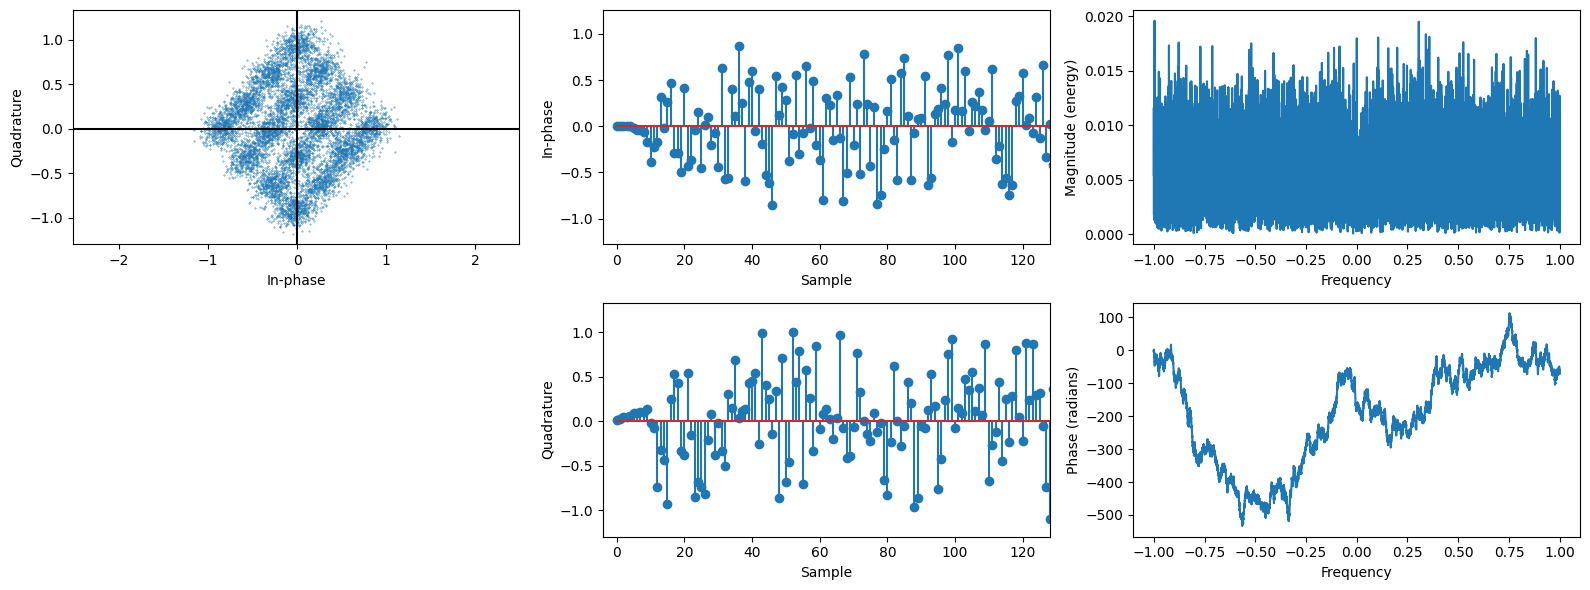

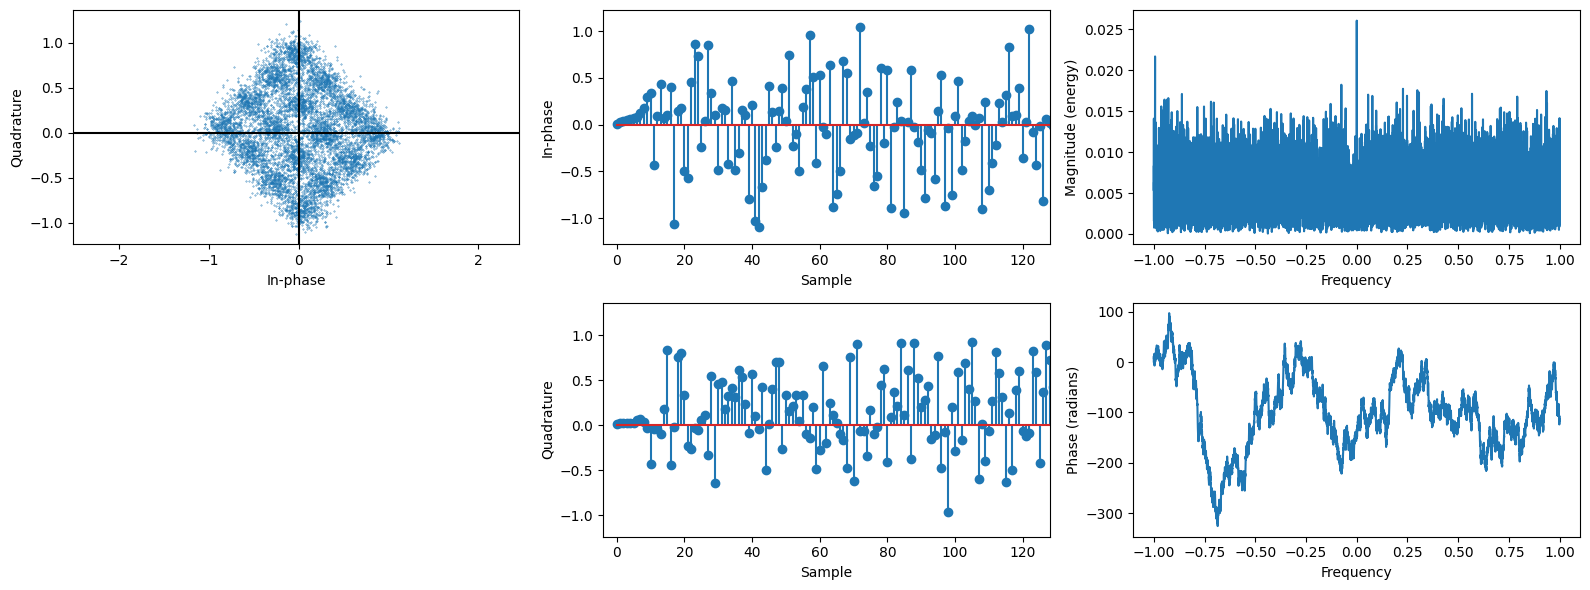

In [82]:
plot_signal(vo[::2])
plot_signal(ve[::2])

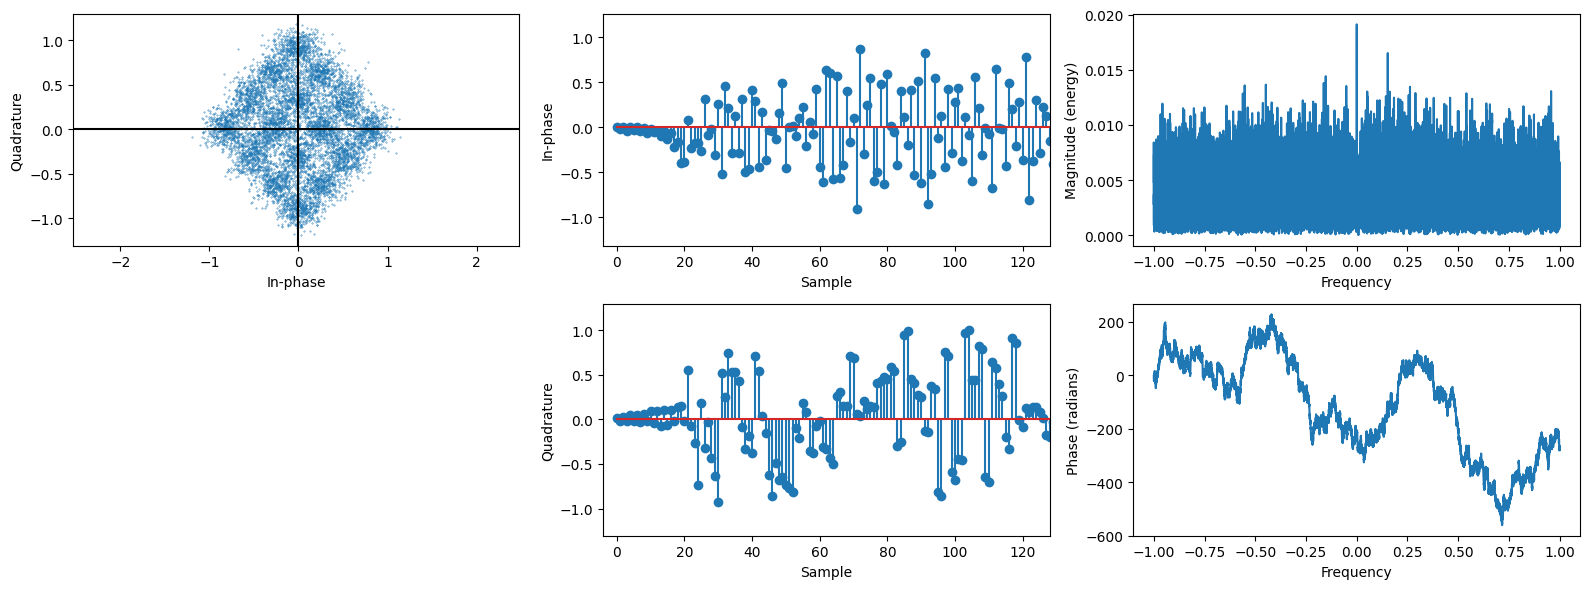

In [84]:
vv = vo.copy()
vv[1::2] = ve[1::2]
plot_signal(vv)

In [102]:
assert rx_16qam.size == 2 * training.size

In [107]:
for i in range(-50, 50):
    aeq = AdaptiveEqualizerAlamouti(49, 1e-5, 0.05, Modulator16QAM(), Demodulator16QAM(), np.roll(training, i), True)
    aeq.w11 = w11
    aeq.w12 = w12
    aeq.w21 = w21
    aeq.w22 = w22
    # rx_aeq = aeq(rx_16qam)
    rx_aeq = aeq(np.tile(r11, 1), np.tile(r22, 1))

    print(i, np.mean(np.abs(aeq.e_oC_log)), np.mean(np.abs(aeq.e_eC_log)))


-50 0.9520079651719113 0.948999053840544
-49 0.9488972523643995 0.9515925811189758
-48 0.9512996038735058 0.9492826054225989
-47 0.9493320492700184 0.9521827363412743
-46 0.9514340363608493 0.9498004210577596
-45 0.9491931876323674 0.9504670723051956
-44 0.9513626495439631 0.9482607787170262
-43 0.9495851925864667 0.951679756558091
-42 0.9518761099597972 0.9485769397741532
-41 0.9490898672560911 0.9510897989173812
-40 0.9509387101222893 0.9494746710506983
-39 0.9489131539806797 0.9506619458242715
-38 0.9510786120194267 0.9495561399655061
-37 0.9486680495424435 0.9507931843388451
-36 0.9517289944980775 0.9487966576940264
-35 0.9491219459880191 0.951099661088092
-34 0.9518350957648587 0.9483894606075554
-33 0.9494801129772367 0.9508344348247848
-32 0.9509366317306156 0.9496006862520525
-31 0.9502447667980995 0.9501692784463982
-30 0.952018685728058 0.9490097665373785
-29 0.9500187662001354 0.950430967014189
-28 0.9521323631879535 0.9494983557620293
-27 0.9491453603950708 0.95075433260385

KeyboardInterrupt: 

In [110]:
aeq = AdaptiveEqualizerAlamouti(49, 1e-5, 0.05, Modulator16QAM(), Demodulator16QAM(), training, True)
aeq.w11 = w11
aeq.w12 = w12
aeq.w21 = w21
aeq.w22 = w22
# rx_aeq = aeq(rx_16qam)
rx_aeq = aeq(np.tile(r11, 1), np.tile(r22, 1))

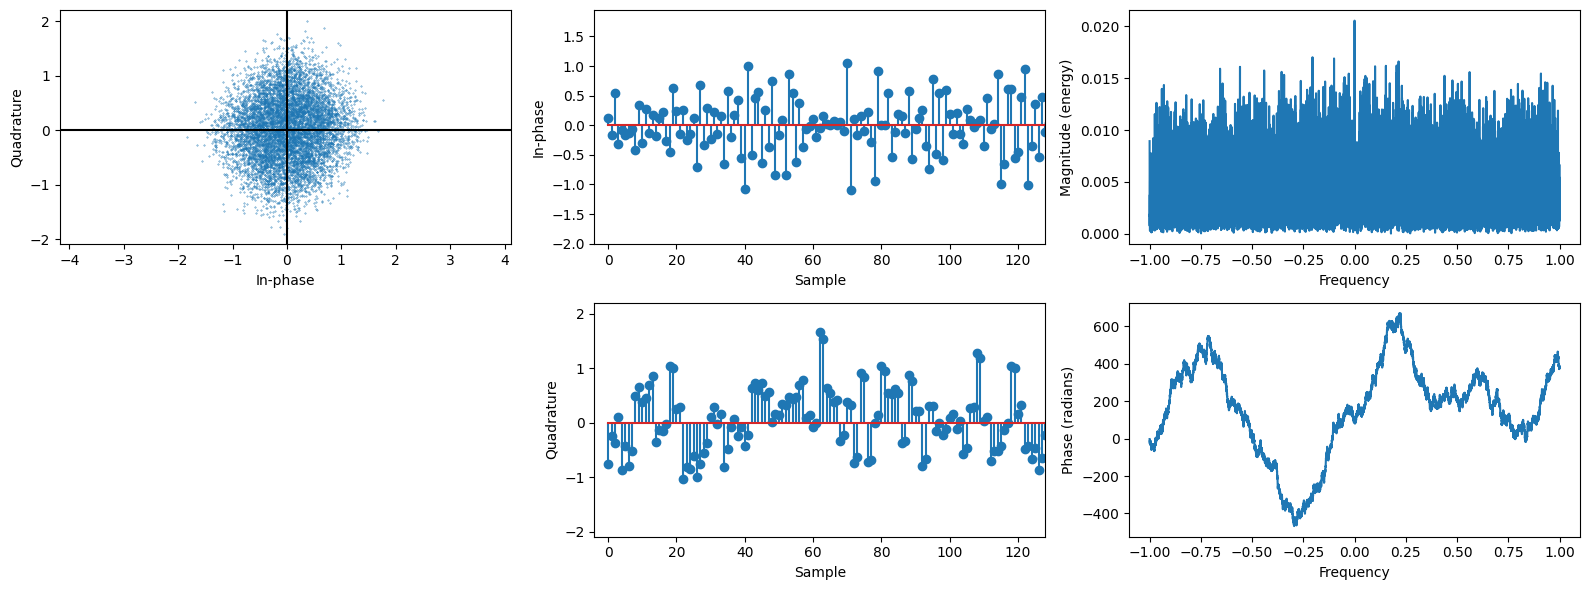

In [111]:
plot_signal(rx_aeq)

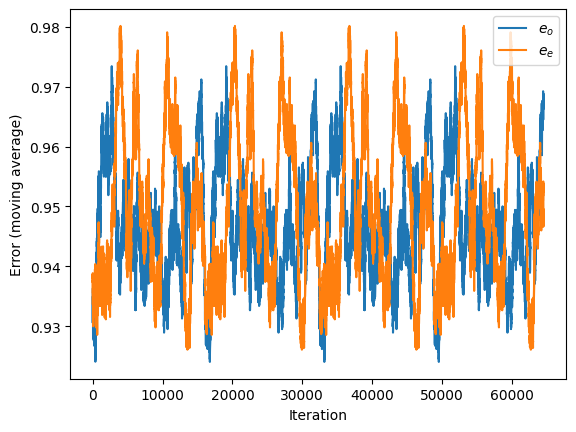

In [101]:
def ma(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.plot(ma(np.abs(aeq.e_oC_log), 1_000), label="$e_o$")
plt.plot(ma(np.abs(aeq.e_eC_log), 1_000), label="$e_e$")
plt.ylabel("Error (moving average)")
plt.xlabel("Iteration")
plt.legend()
plt.show()

In [42]:
# np.mean(signal.group_delay((aeq.w12, 1))[1])

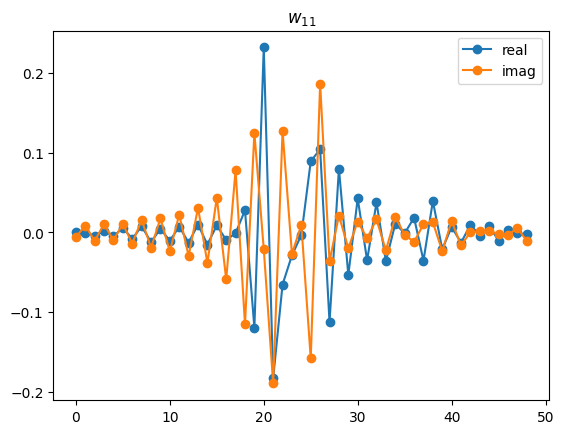

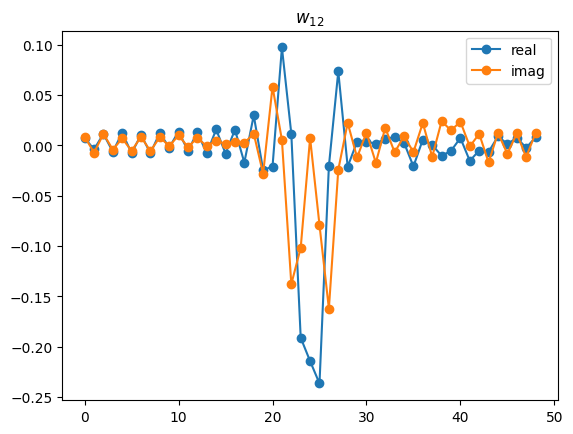

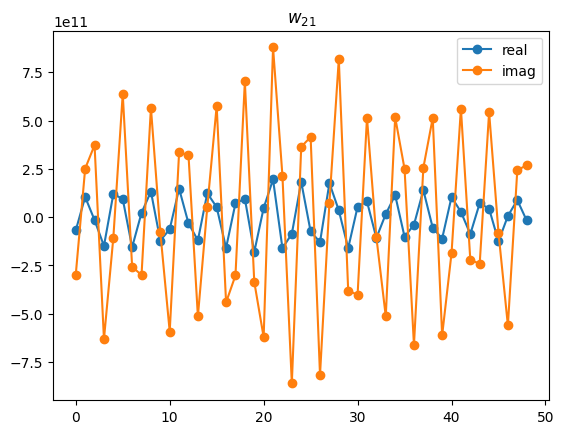

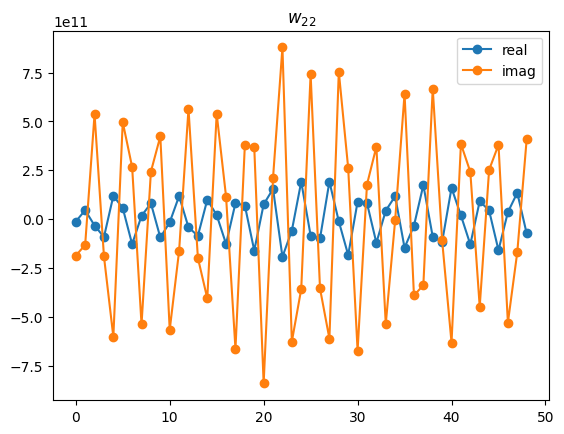

In [43]:
plt.plot(np.real(aeq.w11), "o-", label="real")
plt.plot(np.imag(aeq.w11), "o-", label="imag")
plt.title("$w_{11}$")
plt.legend()
plt.show()
plt.plot(np.real(aeq.w12), "o-", label="real")
plt.plot(np.imag(aeq.w12), "o-", label="imag")
plt.title("$w_{12}$")
plt.legend()
plt.show()
plt.plot(np.real(aeq.w21), "o-", label="real")
plt.plot(np.imag(aeq.w21), "o-", label="imag")
plt.title("$w_{21}$")
plt.legend()
plt.show()
plt.plot(np.real(aeq.w22), "o-", label="real")
plt.plot(np.imag(aeq.w22), "o-", label="imag")
plt.title("$w_{22}$")
plt.legend()
plt.show()

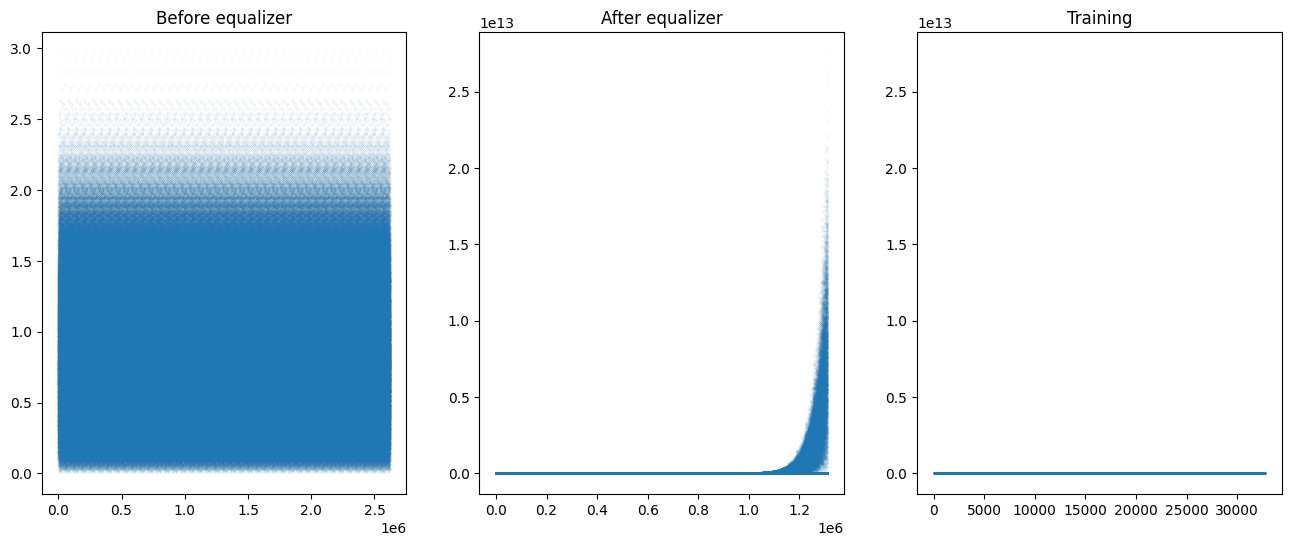

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(16,6))
axs[0].scatter(range(rx_16qam.size), np.abs(rx_16qam), s=0.001)
axs[0].set_title("Before equalizer")
axs[1].scatter(range(rx_aeq.size), np.abs(rx_aeq), s=0.001)
axs[1].set_title("After equalizer")
axs[2].scatter(range(data_ref.size), np.abs(data_ref), s=0.001)
axs[2].set_title("Training")
axs[2].set_ylim(*axs[1].get_ylim())
plt.show()

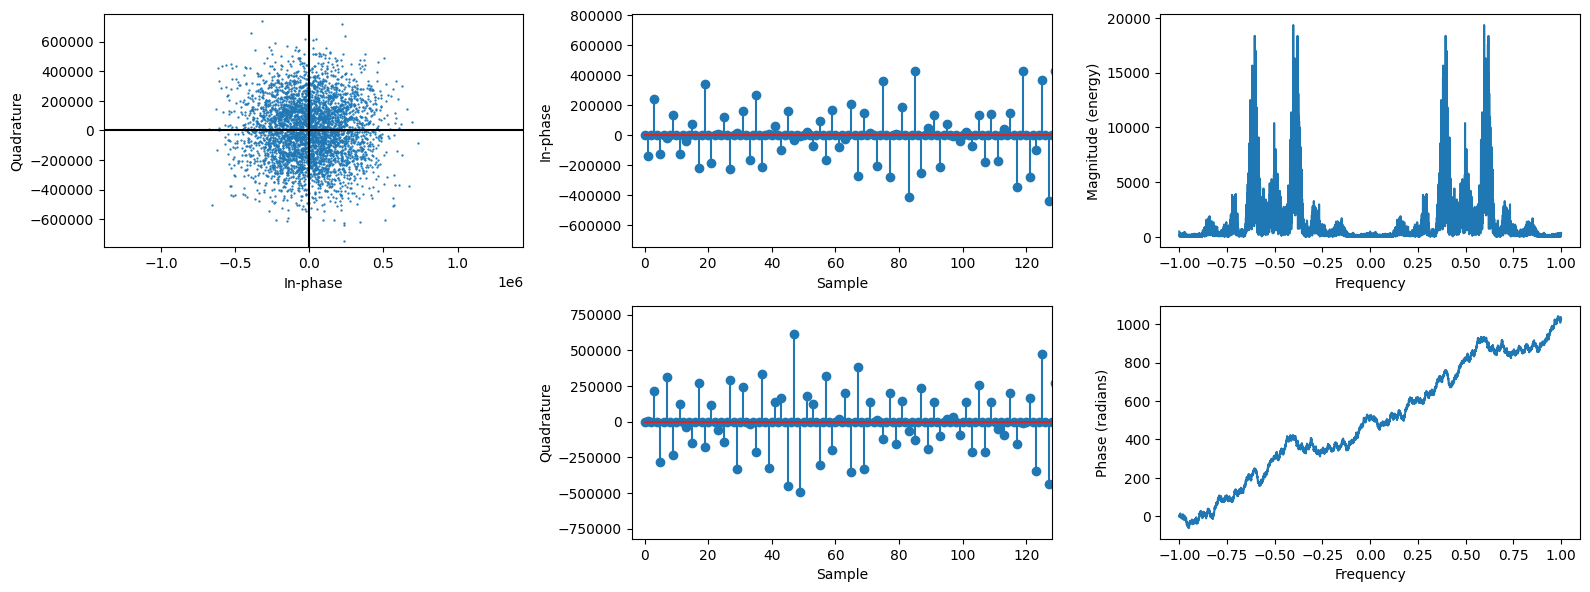

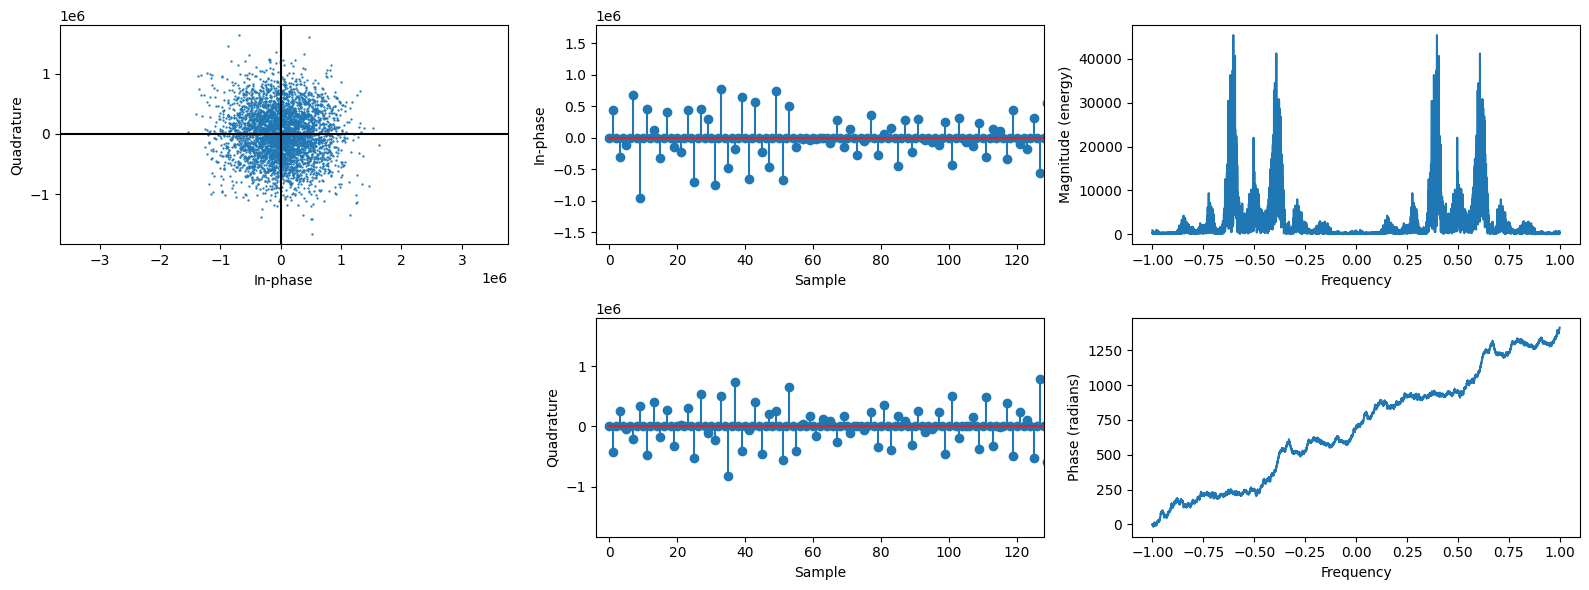

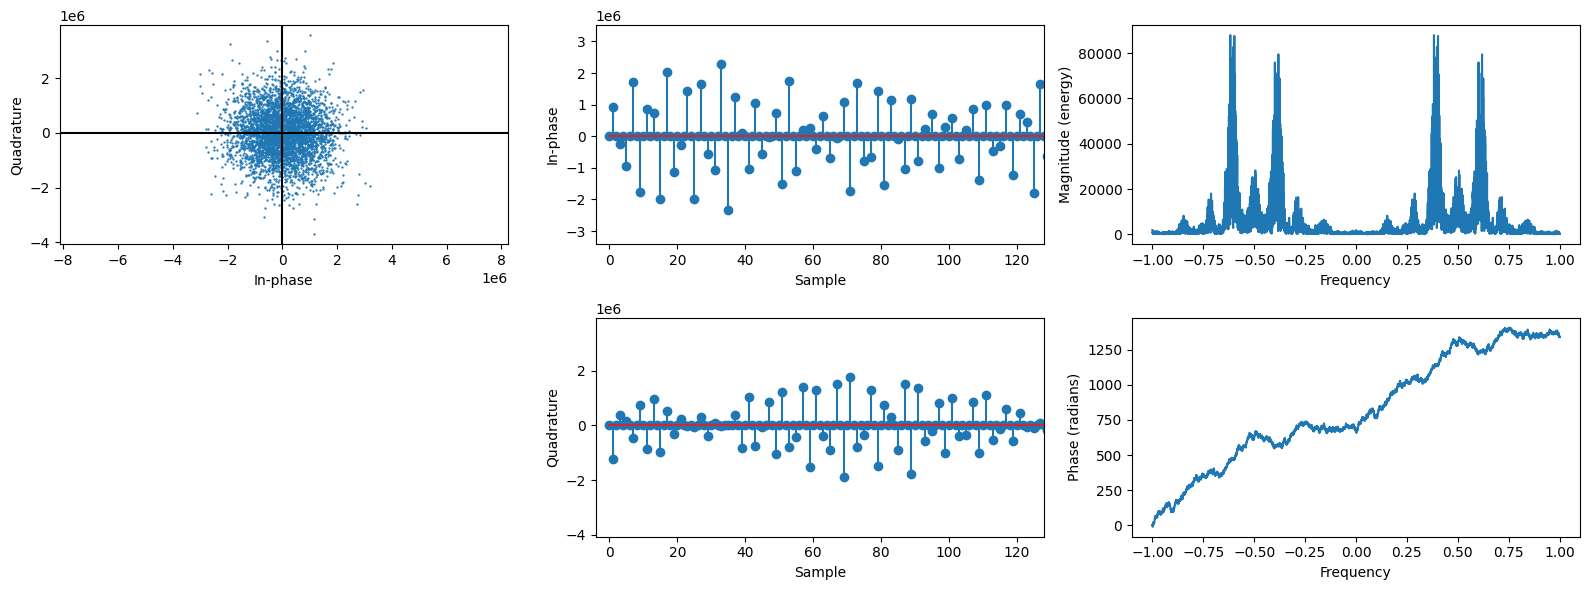

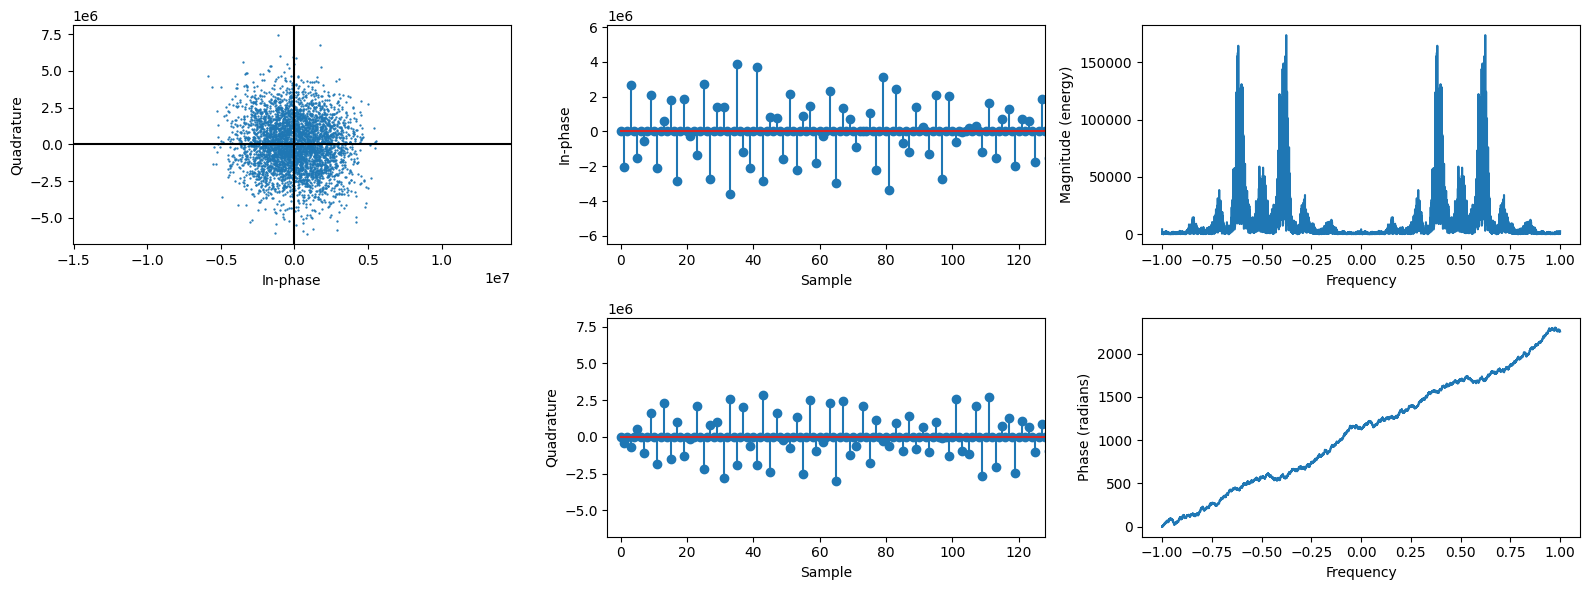

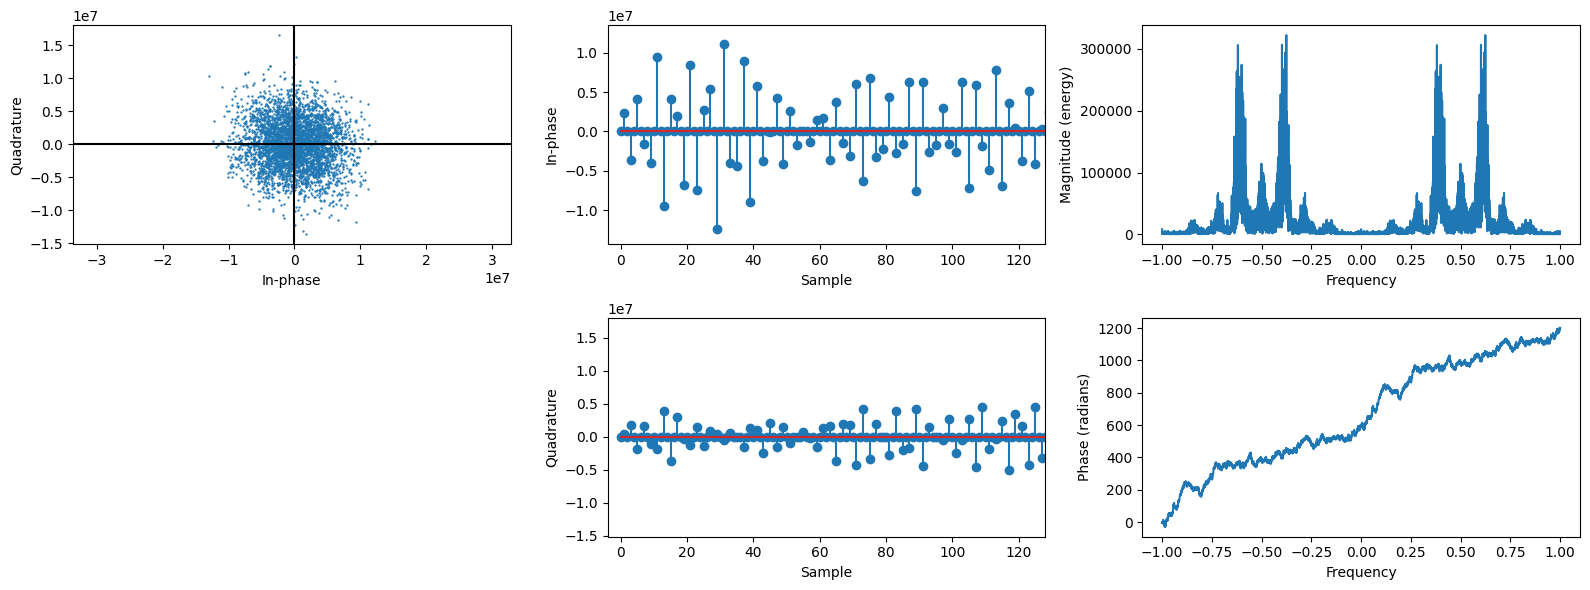

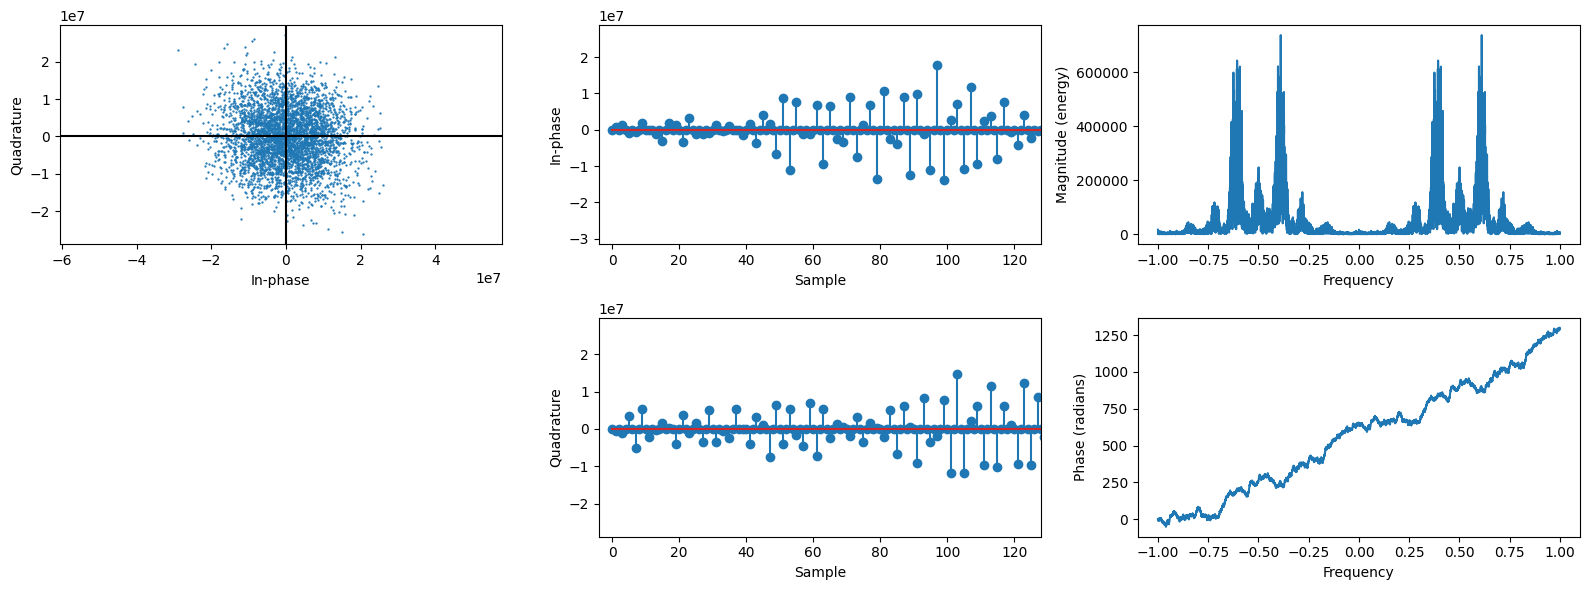

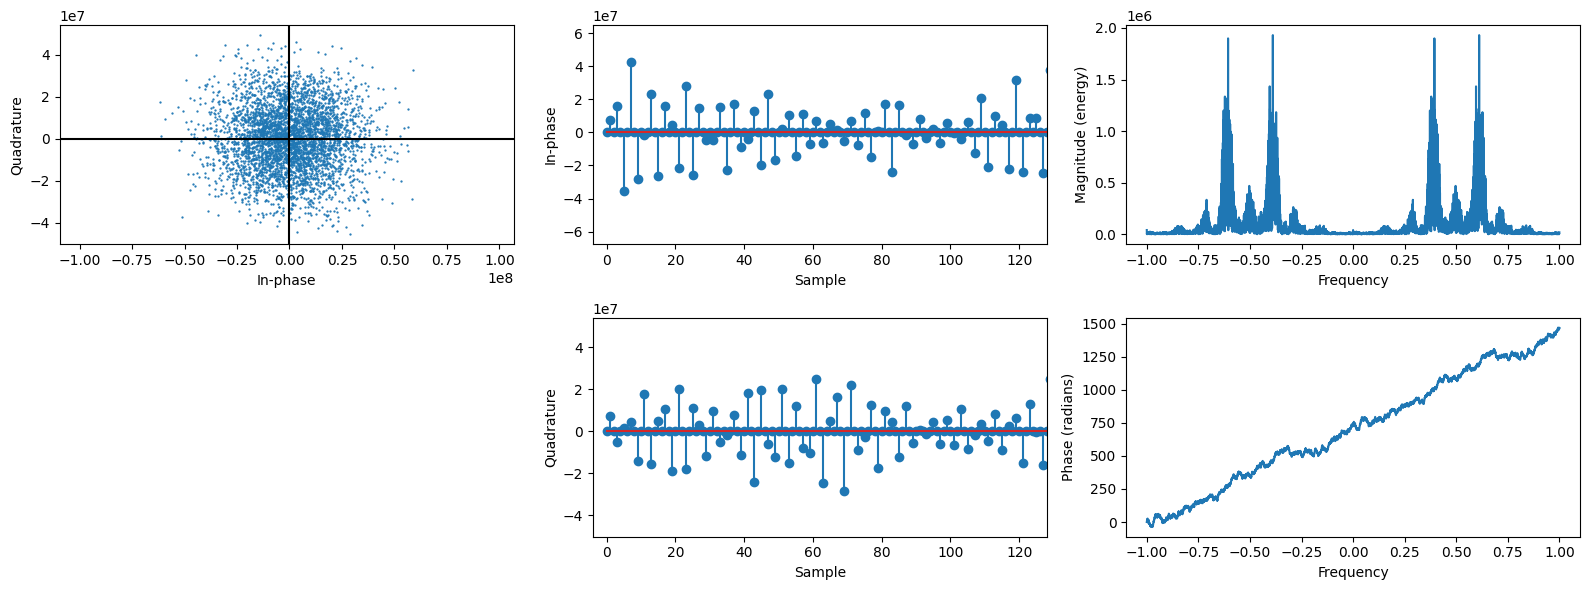

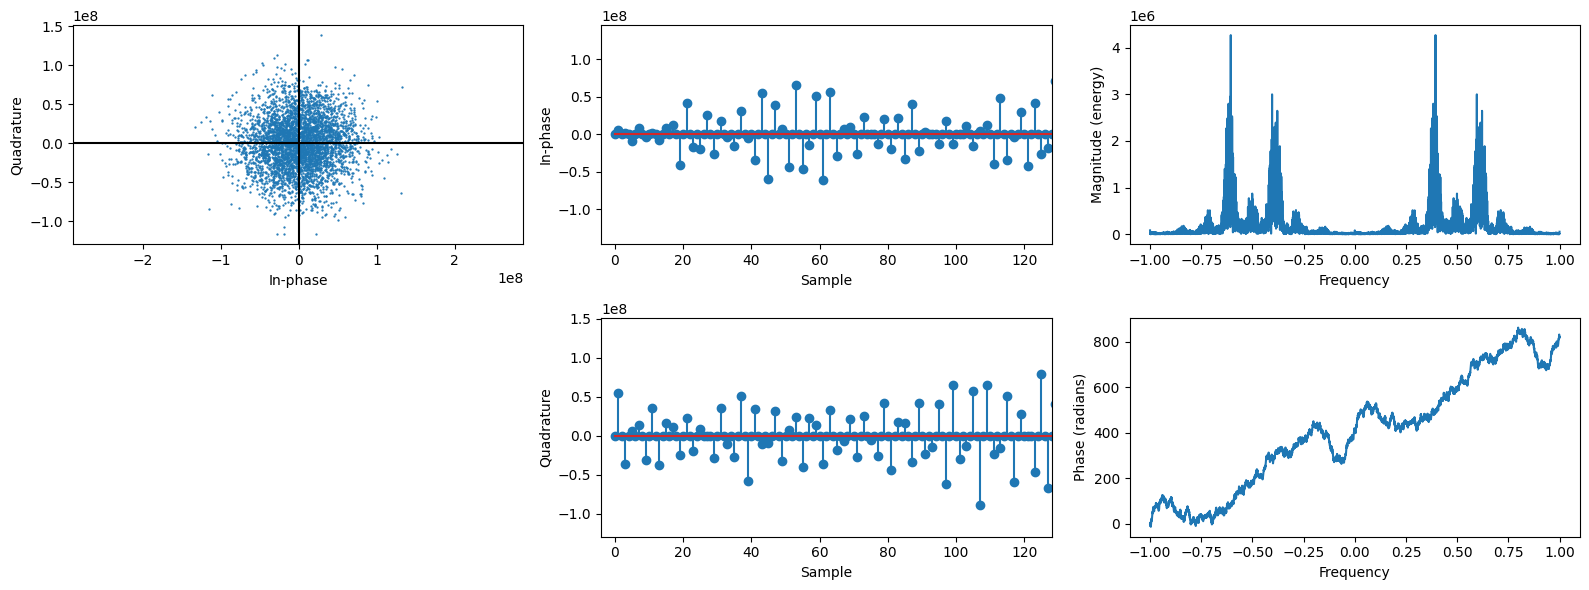

In [45]:
for i in range(8):
    i += 20
    plot_signal(rx_aeq[i * 30_000 : i * 30_000 + 10_000], size=0.4)

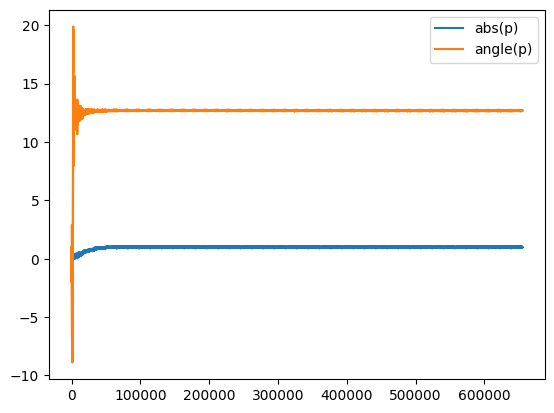

In [46]:
plt.plot(np.abs(aeq.p_log), label="abs(p)")
plt.plot(np.unwrap(np.angle(aeq.p_log)), label="angle(p)")
plt.legend()
plt.show()

In [47]:
# XXX scale parameter != 1
# XXX subtracting the mean seems to help slightly
rx_demod = Demodulator16QAM()(rx_aeq - rx_aeq.mean()) #, scale=1)

In [48]:
from numpy.typing import NDArray


def find_lag(ref: NDArray[np.bool_], sig: NDArray[np.bool_]) -> int:
    corr = scipy.signal.correlate(ref.astype(np.float64), sig.astype(np.float64))
    lags = scipy.signal.correlation_lags(ref.size, sig.size)

    lag = lags[np.argmax(corr)]

    return lag


def compare_streams(
    ref: NDArray[np.bool_], sig: NDArray[np.bool_]
) -> tuple[float, float]:
    lag = find_lag(ref, sig[:2**15])
    print(lag)

    sig_slice = sig[-lag : -lag + ref.size]
    assert ref.size == sig_slice.size

    ber = np.count_nonzero(ref ^ sig_slice) / sig_slice.size

    return lag, ber

In [49]:
# ref_demod = Demodulator16QAM()(np.tile(data_ref, 10))[:rx_demod.size]
ref_demod = Demodulator16QAM()(data_ref, scale=1)
compare_streams(ref_demod, rx_demod)

60671


AssertionError: 

In [91]:
vv_demod = Demodulator16QAM()(vv * np.exp(7j * np.pi / 4))
compare_streams(ref_demod[4_000:24_000], vv_demod)

-4096


(-4096, 0.2711)

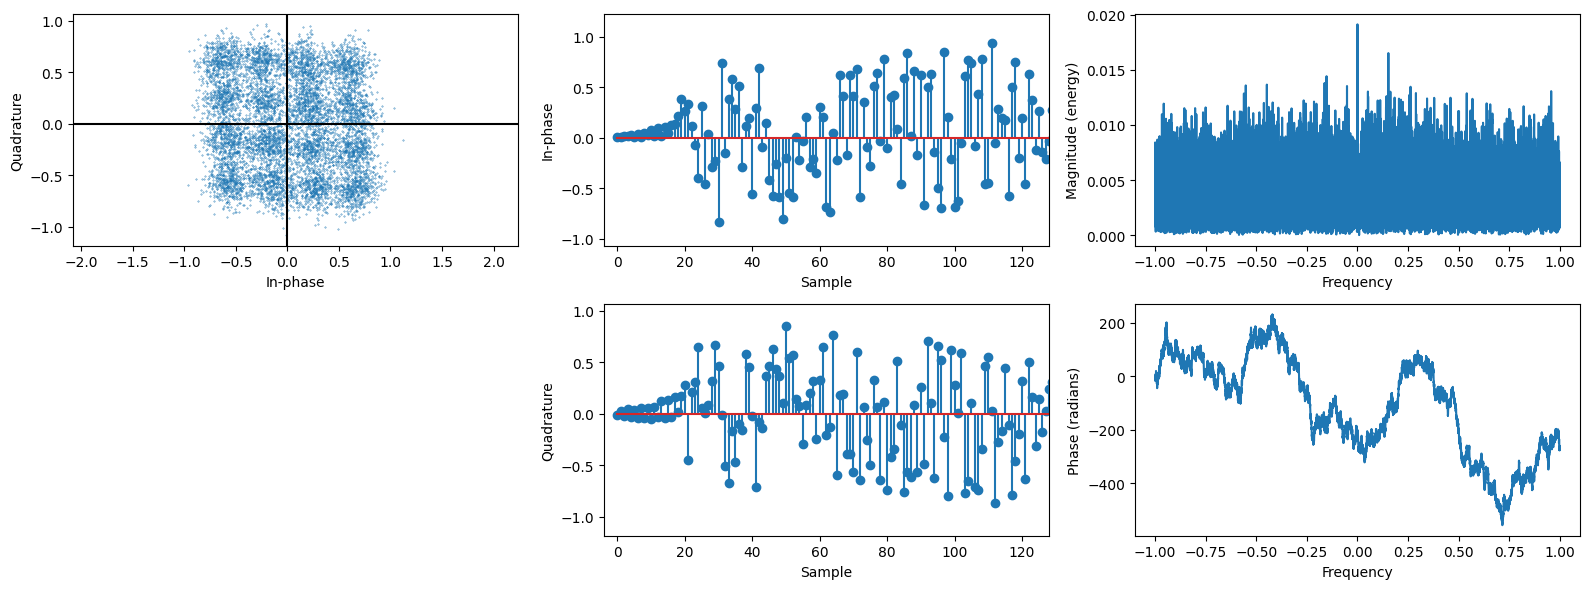

In [85]:
plot_signal(vv * np.exp(5j * np.pi / 4))

(-50.0, 0.0)

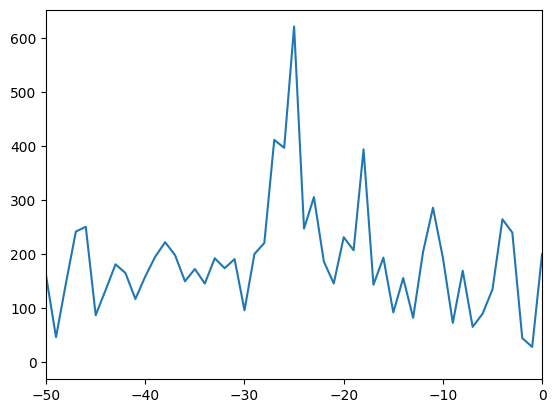

In [ ]:
plt.plot(scipy.signal.correlation_lags(data_ref.size, vv.size), np.abs(scipy.signal.correlate(data_ref, vv, "full")))
plt.xlim(-50, 0)

In [ ]:
# TODO
# Visualise error distribution
# CD Compensation + Shorter equalizer (equalizer issue vs carrier recovery issue)
# Ask for other data: back-to-back, greater power level